Installing necessary libraries

In [2]:
!pip install --upgrade --ignore-installed kaggle

     |████████████████████████████████| 61kB 4.6MB/s 
     |████████████████████████████████| 153kB 13.5MB/s 
     |████████████████████████████████| 235kB 17.8MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 71kB 7.2MB/s 
     |████████████████████████████████| 143kB 23.1MB/s 
     |████████████████████████████████| 184kB 23.6MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 
     |████████████████████████████████| 81kB 6.7MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=8fed9f7b3b2c91430bd7d2972d482c6874be2acb9d4912ab436c494944bf058d
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
  Created wheel for python-slugify: filename=python_slugify-4.0.1-py2.py3-none-any.whl size=6769 sha256=507e4d157986349b02b6cda6bc923e9bc85135a43b423a0c50a7f73b144a11f0
  Stored in directory: /root/.cache/pip/wheels/67/b8/ba/041548f30a6fc058c9b3f7

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ameeraarif","key":"5a2c5d37596e760db6ffa8449f89a47a"}'}

In [4]:
!mkdir ~/.kaggle #created at root folder in colab
#copy
!cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d puneet6060/intel-image-classification

 97% 337M/346M [00:05<00:00, 81.9MB/s]
100% 346M/346M [00:05<00:00, 67.5MB/s]


In [5]:
#unzip dataset in colab session
!unzip -q intel-image-classification.zip # -q for quiet
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
# copy zipped dataset into your drive
!cp "/content/intel-image-classification.zip" /content/drive/MyDrive/


In [ ]:
!unzip Test_data.zip -d pred_data2

unzip:  cannot find or open Test_data.zip, Test_data.zip.zip or Test_data.zip.ZIP.


Importing libraries

In [ ]:

import os
import sys
import datetime
import glob as glob
import numpy as np
import cv2
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD
import tensorflow
# from scipy.interpolate import spline
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Uploading data

In [ ]:
img_width, img_height = 32, 32

train_dir = '/content/seg_train/seg_train'
validate_dir = '/content/seg_test/seg_test'
nb_epochs = 20
batch_size = 32
nb_classes = len(glob.glob(train_dir + '/*'))

# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
# get number of images in validation directory
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))

Data augmentation

In [ ]:
# data pre-processing for training
train_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20, #best
    # width_shift_range = 0.2,
    height_shift_range = 0.2, #best
    shear_range = 0.2, #best
    # zoom_range = 0.2,
    # fill_mode = 'nearest',
    horizontal_flip = True)

# data pre-processing for validation
validate_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20, #best
    # width_shift_range = 0.2,
    height_shift_range = 0.2, #best
    shear_range = 0.2, #best
    # zoom_range = 0.2,
    # fill_mode = 'nearest',
    horizontal_flip = True)

In [ ]:
# generate and store training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


Transfer learning

In [ ]:
# set up transfer learning on pre-trained ImageNet VGG16 model - remove fully connected layer and replace
# with softmax for classifying the number of classes in the dataset
vgg16_model = VGG16(weights = 'imagenet', include_top = False)
x = vgg16_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
input = vgg16_model.input
output = predictions
model = Model(input , output )

In [ ]:
# freeze all layers of the pre-trained InceptionV3 model
for layer in vgg16_model.layers:
    layer.trainable = False

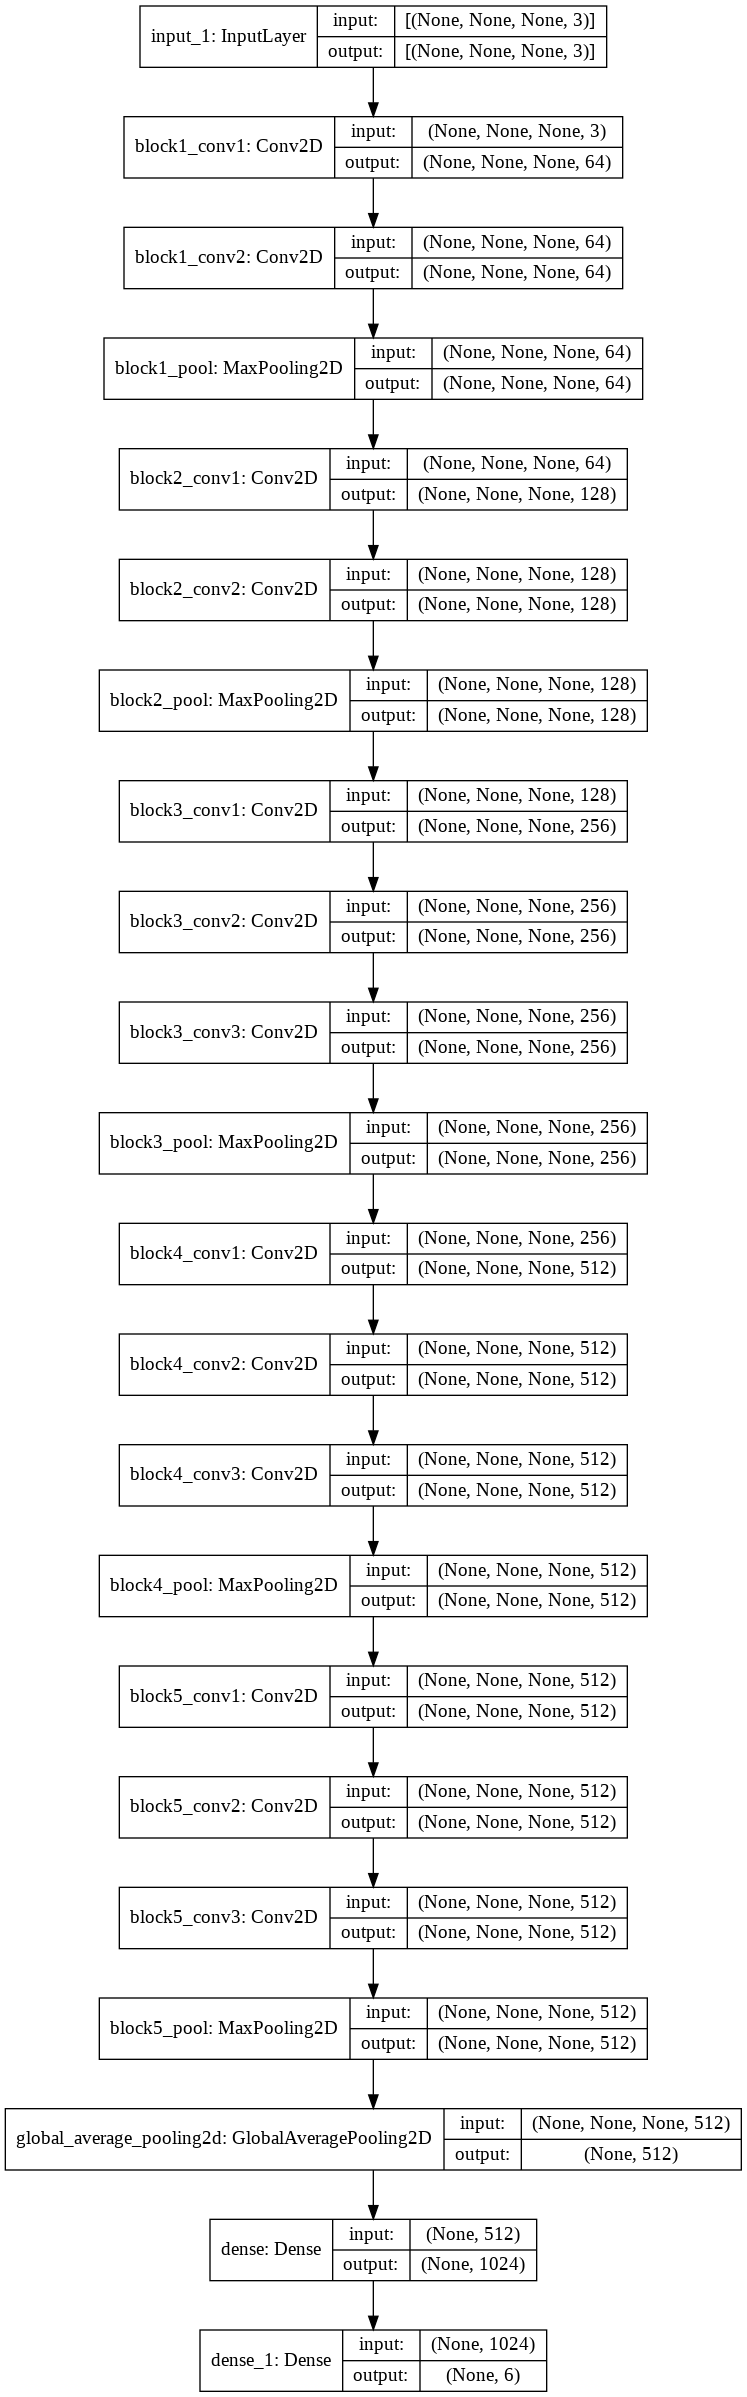

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='modelT+A.png', show_shapes=True)

In [ ]:
# compile the new model using a RMSProp optimizer
model.compile(optimizer = 'rmsprop',
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_historyRMSprop = model.fit(train_generator, batch_size=128,
              epochs=50, 
              validation_data=validate_generator)

print('Training time: %s' % (now() - t))

Epoch 1/50
439/439 [==============================] - 22s 49ms/step - loss: 0.2037 - accuracy: 0.7600 - val_loss: 0.2339 - val_accuracy: 0.7203
Epoch 2/50
439/439 [==============================] - 21s 48ms/step - loss: 0.1938 - accuracy: 0.7746 - val_loss: 0.2246 - val_accuracy: 0.7370
Epoch 3/50
439/439 [==============================] - 21s 48ms/step - loss: 0.1988 - accuracy: 0.7617 - val_loss: 0.2262 - val_accuracy: 0.7417
Epoch 4/50
439/439 [==============================] - 21s 48ms/step - loss: 0.1920 - accuracy: 0.7710 - val_loss: 0.2239 - val_accuracy: 0.7407
Epoch 5/50
439/439 [==============================] - 21s 48ms/step - loss: 0.1899 - accuracy: 0.7741 - val_loss: 0.2218 - val_accuracy: 0.7490
Epoch 6/50
439/439 [==============================] - 21s 49ms/step - loss: 0.1877 - accuracy: 0.7821 - val_loss: 0.2246 - val_accuracy: 0.7383
Epoch 7/50
439/439 [==============================] - 21s 49ms/step - loss: 0.1861 - accuracy: 0.7779 - val_loss: 0.2307 - val_accuracy:

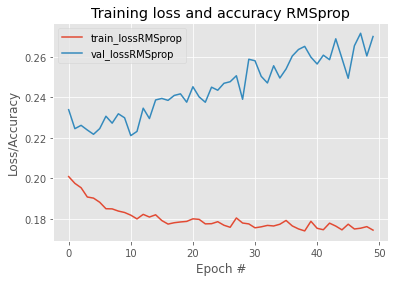

<Figure size 432x288 with 0 Axes>

In [ ]:

import matplotlib.pyplot as plt
N = np.arange(0, 50)
plt.style.use('ggplot')
plt.figure()

plt.plot(N, transfer_learning_historyRMSprop.history['loss'], label='train_lossRMSprop')
plt.plot(N, transfer_learning_historyRMSprop.history['val_loss'], label='val_lossRMSprop')
# plt.plot(N, transfer_learning_historyRMSprop.history['accuracy'], label='train_accuracyRMSprop')
# plt.plot(N, transfer_learning_historyRMSprop.history['val_accuracy'], label='val_accuracyRMSprop')


plt.title('Training loss and accuracy RMSprop')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()
plt.savefig('best_accuracytransfer_learning_historyRMSprop.png')

In [ ]:
# compile the new model using a Adam optimizer
model.compile(optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_historyadam = model.fit(train_generator, batch_size=128,
              epochs=50, 
              validation_data=validate_generator)

print('Training time: %s' % (now() - t))

Epoch 1/50
439/439 [==============================] - 22s 49ms/step - loss: 0.1729 - accuracy: 0.8001 - val_loss: 0.2493 - val_accuracy: 0.7300
Epoch 2/50
439/439 [==============================] - 21s 48ms/step - loss: 0.1686 - accuracy: 0.8055 - val_loss: 0.2488 - val_accuracy: 0.7280
Epoch 3/50
439/439 [==============================] - 21s 48ms/step - loss: 0.1703 - accuracy: 0.8058 - val_loss: 0.2404 - val_accuracy: 0.7420
Epoch 4/50
439/439 [==============================] - 21s 48ms/step - loss: 0.1647 - accuracy: 0.8088 - val_loss: 0.2504 - val_accuracy: 0.7367
Epoch 5/50
439/439 [==============================] - 21s 48ms/step - loss: 0.1653 - accuracy: 0.8081 - val_loss: 0.2427 - val_accuracy: 0.7280
Epoch 6/50
439/439 [==============================] - 21s 48ms/step - loss: 0.1642 - accuracy: 0.8072 - val_loss: 0.2565 - val_accuracy: 0.7243
Epoch 7/50
439/439 [==============================] - 21s 49ms/step - loss: 0.1576 - accuracy: 0.8106 - val_loss: 0.2363 - val_accuracy:

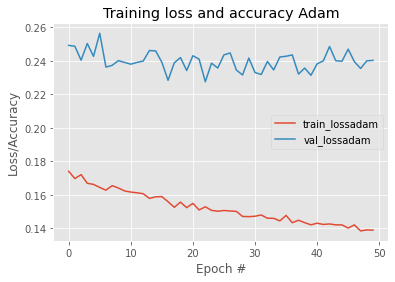

<Figure size 432x288 with 0 Axes>

In [ ]:

import matplotlib.pyplot as plt
N = np.arange(0, 50)
plt.style.use('ggplot')
plt.figure()

plt.plot(N, transfer_learning_historyadam.history['loss'], label='train_lossadam')
plt.plot(N, transfer_learning_historyadam.history['val_loss'], label='val_lossadam')
# plt.plot(N, transfer_learning_historyadam.history['accuracy'], label='train_accuracyadam')
# plt.plot(N, transfer_learning_historyadam.history['val_accuracy'], label='val_accuracyadam')


plt.title('Training loss and accuracy Adam')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()
plt.savefig('best_accuracytransfer_learning_historyadam.png')

BEST

In [ ]:
# compile the new model using a SGD optimizer
model.compile(optimizer = 'sgd',
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_history = model.fit(train_generator, batch_size=128,
              epochs=50, 
              validation_data=validate_generator)

print('Training time: %s' % (now() - t))

Epoch 1/50
439/439 [==============================] - 22s 49ms/step - loss: 1.4834 - accuracy: 0.7926 - val_loss: 0.5507 - val_accuracy: 0.7067
Epoch 2/50
439/439 [==============================] - 22s 49ms/step - loss: 0.5074 - accuracy: 0.7469 - val_loss: 0.4264 - val_accuracy: 0.7143
Epoch 3/50
439/439 [==============================] - 21s 49ms/step - loss: 0.3893 - accuracy: 0.7451 - val_loss: 0.3610 - val_accuracy: 0.7070
Epoch 4/50
439/439 [==============================] - 21s 48ms/step - loss: 0.3495 - accuracy: 0.7432 - val_loss: 0.3308 - val_accuracy: 0.7187
Epoch 5/50
439/439 [==============================] - 21s 49ms/step - loss: 0.3196 - accuracy: 0.7369 - val_loss: 0.3148 - val_accuracy: 0.7040
Epoch 6/50
439/439 [==============================] - 21s 49ms/step - loss: 0.2861 - accuracy: 0.7458 - val_loss: 0.2972 - val_accuracy: 0.7130
Epoch 7/50
439/439 [==============================] - 21s 49ms/step - loss: 0.2756 - accuracy: 0.7557 - val_loss: 0.2821 - val_accuracy:

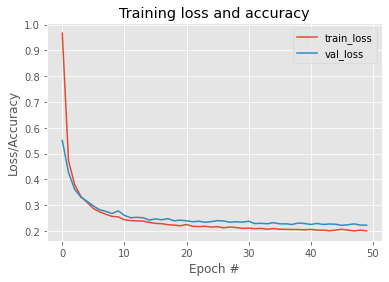

<Figure size 432x288 with 0 Axes>

In [ ]:

import matplotlib.pyplot as plt
N = np.arange(0, 50)
plt.style.use('ggplot')
plt.figure()

plt.plot(N, transfer_learning_history.history['loss'], label='train_loss')
plt.plot(N, transfer_learning_history.history['val_loss'], label='val_loss')
# plt.plot(N, transfer_learning_history.history['accuracy'], label='train_accuracy')
# plt.plot(N, transfer_learning_history.history['val_accuracy'], label='val_accuracy')


plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()
plt.savefig('best_accuracytransfer_learning_history.png')

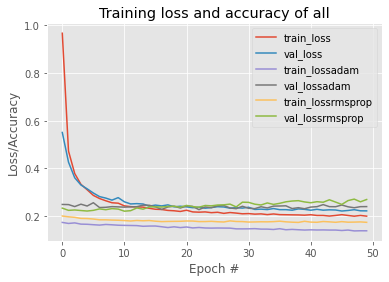

<Figure size 432x288 with 0 Axes>

In [ ]:

import matplotlib.pyplot as plt
N = np.arange(0, 50)
plt.style.use('ggplot')
plt.figure()

plt.plot(N, transfer_learning_history.history['loss'], label='train_loss')
plt.plot(N, transfer_learning_history.history['val_loss'], label='val_loss')
# plt.plot(N, transfer_learning_history.history['accuracy'], label='train_accuracy')
# plt.plot(N, transfer_learning_history.history['val_accuracy'], label='val_accuracy')

plt.plot(N, transfer_learning_historyadam.history['loss'], label='train_lossadam')
plt.plot(N, transfer_learning_historyadam.history['val_loss'], label='val_lossadam')
# plt.plot(N, transfer_learning_historyadam.history['accuracy'], label='train_accuracyadam')
# plt.plot(N, transfer_learning_historyadam.history['val_accuracy'], label='val_accuracyadam')

plt.plot(N, transfer_learning_historyRMSprop.history['loss'], label='train_lossrmsprop')
plt.plot(N, transfer_learning_historyRMSprop.history['val_loss'], label='val_lossrmsprop')
# plt.plot(N, transfer_learning_historyRMSprop.history['accuracy'], label='train_accuracyrmsprop')
# plt.plot(N, transfer_learning_historyRMSprop.history['val_accuracy'], label='val_accuracyrmsprop')



plt.title('Training loss and accuracy of all')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()
plt.savefig('best_accuracytransfer_learning_historyall.png')

In [ ]:
# save transfer learning model for offline prediction purposes
model.save('transfer_learning_aug.h5')

In [ ]:
#  evaluate the performance the new model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])


In [ ]:
'''CONFUSION MATRIX'''
# Making prediction
y_pred = model.predict_classes(X_test)
y_true = np.argmax(y_test, axis=-1)

# Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

In [ ]:
confusion_mtx